# Support Vector Machine

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import preprocessing # LabelEncoder
from sklearn.preprocessing import MinMaxScaler # Escala los datos
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
import scikitplot as skplt 
from string import ascii_uppercase 
# import seaborn as sns
import qgrid
import time
#from sklearn.externals import joblib # Para guardar el modelo
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy import stats #Para la moda
## Gráfica tabla
from tempfile import TemporaryDirectory

import joblib

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve

from sklearn.svm import SVC

In [2]:
def loadModel(path):    
    clf = joblib.load(path)
    
    return clf;

In [3]:
def saveModel(clf, name):
    path = "../../Models/" + name + ".pkl"
    joblib.dump(clf, "model.pkl") 

In [4]:
def loadCSV(pathSamples, pathMatrix):
    df_loaded = pd.read_table(pathMatrix, sep=',')
    data = pd.read_table(pathSamples, sep=',')
    clin_trial_values = df_loaded.values
    
    Y = data['Eligible']
    Y = Y.astype(int)
    X = clin_trial_values[:, :]
    return X, Y

In [5]:
def plot_roc(Xtest, Ytest, probs, xlabel):
    ns_probs = [0 for _ in range(len(Ytest))]
    
    probs = probs[:, 1]
    ns_auc = roc_auc_score(Ytest, ns_probs)
    auc = roc_auc_score(Ytest, probs)  

    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (auc))

    ns_fpr, ns_tpr, _ = roc_curve(Ytest, ns_probs)
    fpr, tpr, _ = roc_curve(Ytest, probs)   

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label= xlabel)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [6]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring='f1',
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [7]:
# F1
def model_SVM_F1(C, kernel, gamma, impresion=True, classifier=None):
    if classifier is not None:
        SVM = SVC(C=C, kernel=kernel, gamma=gamma, probability=True)
    else:
        SVM = classifier
        
    tiempo_i = time.time()
    
    accuracy_list = np.zeros([5,2])
    accuracy_list_train = np.zeros([5,2])
    precision_list = np.zeros([5,2])
    precision_list_train = np.zeros([5,2])
    recall_list = np.zeros([5,2])
    recall_list_train = np.zeros([5,2])
    error = np.zeros([5,2])
    error_train = np.zeros([5,2])
    f_list = np.zeros([5,2]) 
    f1_train = np.zeros([5,2])
    
    skf = StratifiedKFold(n_splits=5)
    
    for i, indexes in enumerate(skf.split(X, Y)):
        #Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.2) # Modificar metodología de validación
        #scaler = MinMaxScaler() #Escala entre 0 y 1
        #Xtrain = scaler.fit_transform(Xtrain)
        #Xtest = scaler.transform(Xtest)
        
        Xtrain, Xtest = X[indexes[0]], X[indexes[1]]
        Ytrain, Ytest = Y[indexes[0]], Y[indexes[1]]

        if classifier is not None:
            SVM.fit(Xtrain, Ytrain)
        
        pred = SVM.predict(Xtest)
        pred_train = SVM.predict(Xtrain)
        
        # accuracy
        _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
        accuracy_list[i] = _accuracy_

        _accuracy_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
        accuracy_list_train[i] = _accuracy_train_

        # recall 
        _recalls_ = recall_score(Ytest, pred, average=None)
        recall_list[i] = _recalls_
        
        _recalls_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
        recall_list_train[i] = _recalls_train_

        # precision 
        _precisions_ = precision_score(Ytest, pred, average=None)
        precision_list[i] = _precisions_
        
        _precisions_train_ = precision_score(Ytrain, pred_train, average=None)
        precision_list_train[i] = _precisions_train_
        
        # f1
        _f_score_ = f1_score(Ytest, pred, average=None)
        f_list[i] = _f_score_
        
        _f_score_train = f1_score(Ytrain, pred_train, average=None)
        f1_train[i] = _f_score_train
          
    if impresion:    
        #Curva ROC
        SVM_probs = SVM.predict_proba(Xtest)
        plot_roc(Xtest, Ytest, SVM_probs, "SVM")

        # Matriz Confusion
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)
        
        report = {
            'f1':[np.around(np.mean(f1_train), decimals=5), np.around(np.std(f1_train), decimals=5), np.around(np.mean(f_list), decimals=5), np.around(np.std(f_list), decimals=5)],
            'accuracy':[np.around(np.mean(accuracy_list_train), decimals=5), np.around(np.std(accuracy_list_train), decimals=5), np.around(np.mean(accuracy_list), decimals=5), np.around(np.std(accuracy_list), decimals=5)],
            'precision':[np.around(np.mean(precision_list_train), decimals=5), np.around(np.std(precision_list_train), decimals=5), np.around(np.mean(precision_list), decimals=5), np.around(np.std(precision_list), decimals=5)],
            'recall':[np.around(np.mean(recall_list_train), decimals=5), np.around(np.std(recall_list_train), decimals=5), np.around(np.mean(recall_list), decimals=5), np.around(np.std(recall_list), decimals=5)]
        }

        print(pd.DataFrame.from_dict(report, orient='index', columns=['Training score', '+/-', 'Test score', '+/-']))

        print("Total time:", time.time()-tiempo_i)

    return np.mean(f1_train), np.std(f1_train), np.mean(f_list), np.std(f_list), time.time()-tiempo_i;

In [8]:
def grid_search(kernel):
    parameters = {'C':[.001,0.01,.1, 1,10,100], 'gamma':[0.01,.1,'auto', 1]}
    SVM = SVC(kernel=kernel)
    clf = GridSearchCV(SVM, parameters, scoring='f1', n_jobs=-1, return_train_score=True)
    clf.fit(X,Y)
    
    # Get Test Scores Mean and std for each grid search
    scores_mean = clf.cv_results_['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(parameters['gamma']),len(parameters['C']))

    scores_sd = clf.cv_results_['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(parameters['gamma']),len(parameters['C']))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1, figsize=(20, 10))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(parameters['gamma']):
        ax.plot(parameters['C'], scores_mean[idx,:], '-o', label= 'gamma' + ': ' + str(val))

    title = "Grid Search Scores (kernel: " + kernel + ")"
    ax.set_title(title, fontsize=20, fontweight='bold')
    ax.set_xlabel('C', fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
    return clf

In [9]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py
def vc(param_name, param_range, C=1, kernel='rbf', gamma='scale'):
    SVM = SVC(C=C, kernel=kernel, gamma=gamma)
    train_scores, test_scores = validation_curve(
        SVC, X, Y, param_name=param_name, param_range=param_range,
        scoring="f1", n_jobs=1)
    return train_scores, test_scores;

# LSA 10k_1Col_NoCarEsp


Latent Semantic Analysis con 10mil muestras. Uniendo las columnas "Diagnoses" e "Interventions". Eliminando todos los caracteres especiales y números de las muestras. Eliminando las 2 palabras que más aparecen y las que sólo aparecen 1-10 veces para hacer el LSA. 1200 tópicos.

In [10]:
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1200.csv") #Cargar SCV

FileNotFoundError: [Errno 2] File b'../../Tables/docsTopicsLSA1200.csv' does not exist: b'../../Tables/docsTopicsLSA1200.csv'

In [11]:
t_s, train_s, test_s, fit_t = model_SVM_F1(1,'rbf', .1)
print("Average train F1 score:", np.mean(train_s), "+/-", np.std(train_s))
print("Average test F1 score:", np.mean(test_s), "+/-", np.std(test_s))
print("Average time:", np.mean(fit_t))

Average train F1 score: 0.943921139738907 +/- 0.0018837588643140896
Average test F1 score: 0.7445636573159982 +/- 0.0014543432025959154
Average time: 9.755158007144928


In [ ]:
param_range = [.0001,.001,.01,.1,1,10,100,1000]
train_scores, test_scores = vc(param_name='C', param_range=param_range)
for scores in enumerate(zip(train_scores, test_scores, param_range)):
    print('C:', scores[3], ', F1 score train:', scores[0], '. Score test:', scores[1])

In [ ]:
## Plot LC

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (LogisticRegression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LogisticRegression(C=0.5, solver='saga', max_iter = 200)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

# Another stimator
#title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
#cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#estimator = SVC(gamma=0.001)
#plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
#                    cv=cv, n_jobs=4)

plt.show()

## LSA, 10k, sin caracteres especiales, 1500 Tópicos

Latent Semantic Analysis con 10mil muestras. Uniendo las columnas "Diagnoses" e "Interventions". Eliminando todos los caracteres especiales y números de las muestras. 1500 tópicos.

In [11]:
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv") #Cargar SCV

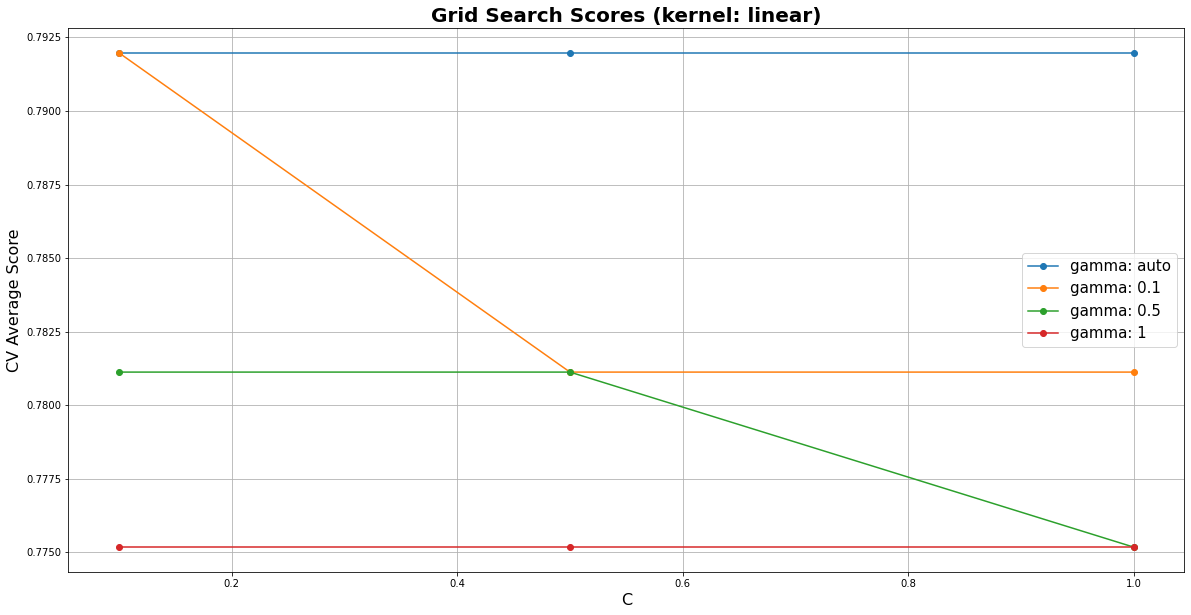

In [12]:
clf_linear = grid_search('linear')clf_linear = grid_search('linear')

/home/juan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/juan/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


NameError: name 'clf' is not defined

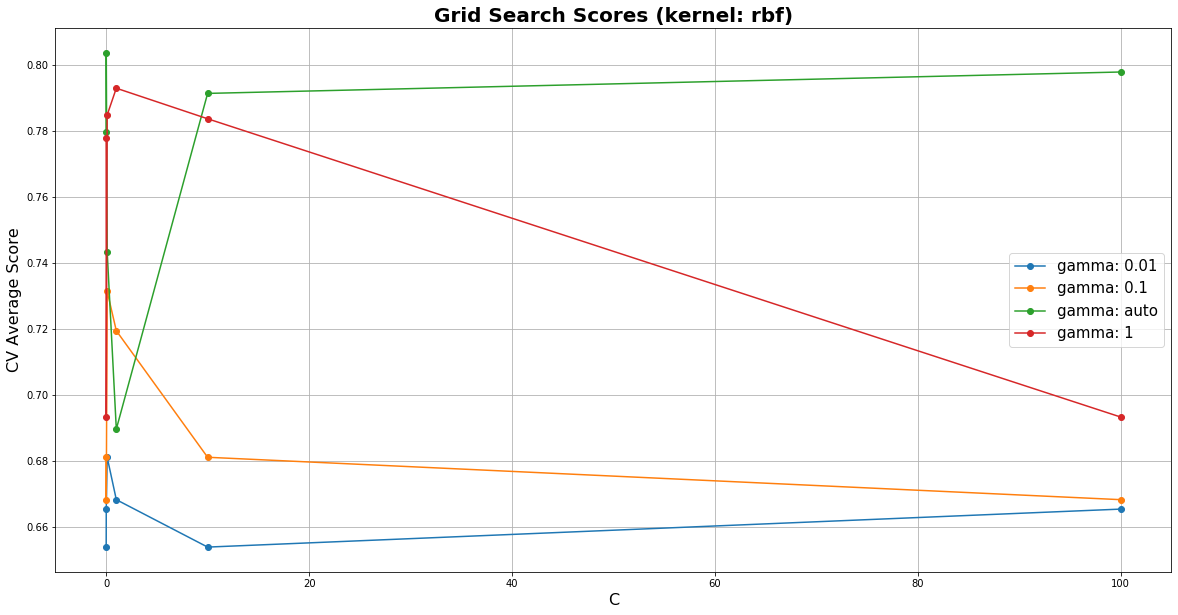

In [12]:
clf_rbf = grid_search('rbf')

In [14]:
clf_rbf.cv_results_
saveModel(clf_rbf, "SVM_LSA_1500")

In [15]:
print(clf_rbf.cv_results_)

{'mean_fit_time': array([256.66677769, 256.19529708, 260.60186958, 262.39814448,
       269.24749541, 270.36086973, 270.55474408, 260.70920149,
       260.09595696, 250.12382078, 266.640481  , 258.95027924,
       203.44974049, 213.76335279, 256.28272669, 257.42051562,
       153.36791571, 245.36765281, 202.57699712, 253.44144408,
       151.57435211, 242.46159053, 158.78424788, 207.14852715]), 'std_fit_time': array([ 0.44057436,  1.18872518,  7.24643699,  2.96573125,  0.24402363,
        2.49320443,  4.09232587,  2.20519221,  1.57013843,  0.62473629,
        0.6618321 ,  2.65368025,  5.56660766,  0.80306861,  2.28866519,
        2.2617785 ,  1.31971054,  2.98140562,  1.56107934,  1.72643392,
        0.77434784,  1.32575296,  2.9147354 , 33.2518117 ]), 'mean_score_time': array([131.43775098, 130.14392455, 129.73375956, 131.07335695,
       131.07611736, 129.52542663, 130.95419947, 130.33133634,
       125.80053933, 122.38114214, 129.84497523, 128.06467859,
        98.11706638, 110.2638

0
1
2
3
4
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.500


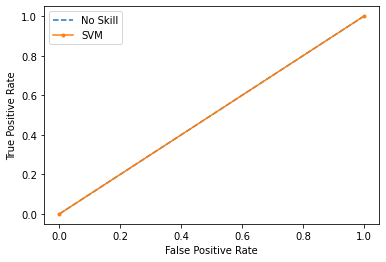

Average train F1 score: 0.5635541616792333 +/- 0.3069334180504128
Average test F1 score: 0.34928703102475706 +/- 0.31920611800225435
Total time: 5879.7146372795105


(0.5635541616792333,
 0.3069334180504128,
 0.34928703102475706,
 0.31920611800225435,
 5879.7146372795105)

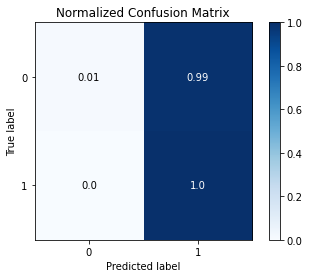

In [25]:
model_SVM_F1(0.1,'rbf',1)